In [10]:
import os, sys, cv2, pydicom

In [11]:
DPATH = '/home/ubuntu/datasets/chest/CBIS-DDSM'
cases = os.listdir(DPATH)

In [12]:
cases[0]

'Mass-Training_P_01753_RIGHT_CC'

In [13]:
ex1 = '%s/%s/%s/%s' % (
    DPATH, cases[0], '07-20-2016-DDSM-62326', '1-full mammogram images-61949')
print(ex1)              
os.listdir(ex1)

/home/ubuntu/datasets/chest/CBIS-DDSM/Mass-Training_P_01753_RIGHT_CC/07-20-2016-DDSM-62326/1-full mammogram images-61949


['000000.dcm']

In [14]:
ex1 = '%s/%s/%s/%s' % (
    DPATH, cases[1], '09-06-2017-DDSM-01087', '1-ROI mask images-46211')
print(ex1)          
os.listdir(ex1)

/home/ubuntu/datasets/chest/CBIS-DDSM/Calc-Training_P_00112_LEFT_CC_4/09-06-2017-DDSM-01087/1-ROI mask images-46211


['000000.dcm', '000001.dcm']

In [15]:
import matplotlib.pyplot as plt

metadata = {}

def check_exists(pid, sid):
    # indexed by scan id = PatientID + Side + Angle
    if sid not in metadata:
        metadata[sid] = {
            'pid': pid, 'sid': sid, 'label': 'cancer',
            'image': None,
            'masks': [],
        }
        
def get_pid(cname):
    pid = cname.split('P_')[1]
    if 'LEFT' in pid: pid = pid.split('_LEFT')[0]
    if 'RIGHT' in pid: pid = pid.split('_RIGHT')[0]
    return pid

def get_scanid(cname):
    sid = cname.split('P_')[1]
    for ii in range(1, 8):
        sid = sid.split('_%d' % ii)[0]
    return sid

__msizes = []
def spider(cname):
    global __missing, __msizes
    dfolder = os.listdir('%s/%s' % (DPATH, cname))
    sid = get_scanid(cname)
    check_exists(get_pid(cname), sid)
    for df in dfolder:
        tfolder = os.listdir('%s/%s/%s' % (DPATH, cname, df))
        for tf in tfolder:
            fullpath = '%s/%s/%s/%s' % (DPATH, cname, df, tf)
            files = os.listdir(fullpath)
            if 'ROI' in tf:
                for fl in files:
                    isMask = False
                    with pydicom.dcmread('%s/%s' % (fullpath, fl)) as db:
                        try:
                            isMask = 'mask' in db.SeriesDescription
                        except:
                            isMask = db.Rows > 3700 # infer filetype from data size
                            __msizes.append(db.Rows)
                        if isMask:
                            metadata[sid]['masks'].append('%s/%s' % (fullpath, fl))
            elif 'cropped' in tf:
                pass
            else: # full image
                assert len(files) == 1
                imfile = files[0]
                impath = '%s/%s'% (fullpath, imfile)
                metadata[sid]['image'] = impath
                
for ii, cs in enumerate(cases):
    spider(cs)
    if ii % 20 == 0:
        sys.stdout.write('%d/%d  Count: %d   Msn: %d        \r' % (
            ii, len(cases), len(metadata), len(__msizes)))
        sys.stdout.flush()

In [16]:
import numpy as np

print('%d LEFT + RIGHT MLO and CC shots' % len(metadata))
msk = [ent for case, ent in metadata.items() if len(ent['masks']) > 0 and 'image' not in ent]
print('%d       --       mask only' % len(msk))
imonly = [ent for case, ent in metadata.items() if len(ent['masks']) == 0 and 'image' in ent]
print('%d       --       images only' % len(imonly))

hasmasks = [ent for case, ent in metadata.items() if len(ent['masks']) > 0 and 'image' in ent]
print('%d Has both images and masks' % len(hasmasks))

cc = [ent for ent in hasmasks if 'CC' in ent['sid']]
mlo = [ent for ent in hasmasks if 'MLO' in ent['sid']]
print('%d CC shots' % len(cc))
print('%d MLO shots' % len(mlo))


tosave = hasmasks

3032 LEFT + RIGHT MLO and CC shots
0       --       mask only
1       --       images only
3031 Has both images and masks
1427 CC shots
1604 MLO shots


In [17]:
import json

with open('.cbis_cache.json', 'w') as fl:
    json.dump(tosave, fl, indent=4)
    
# with open('.cbis_cache.json') as fl:
#     tosave = json.load(fl)



In [18]:
import matplotlib.pyplot as plt

(5251, 2386) (5251, 2386)


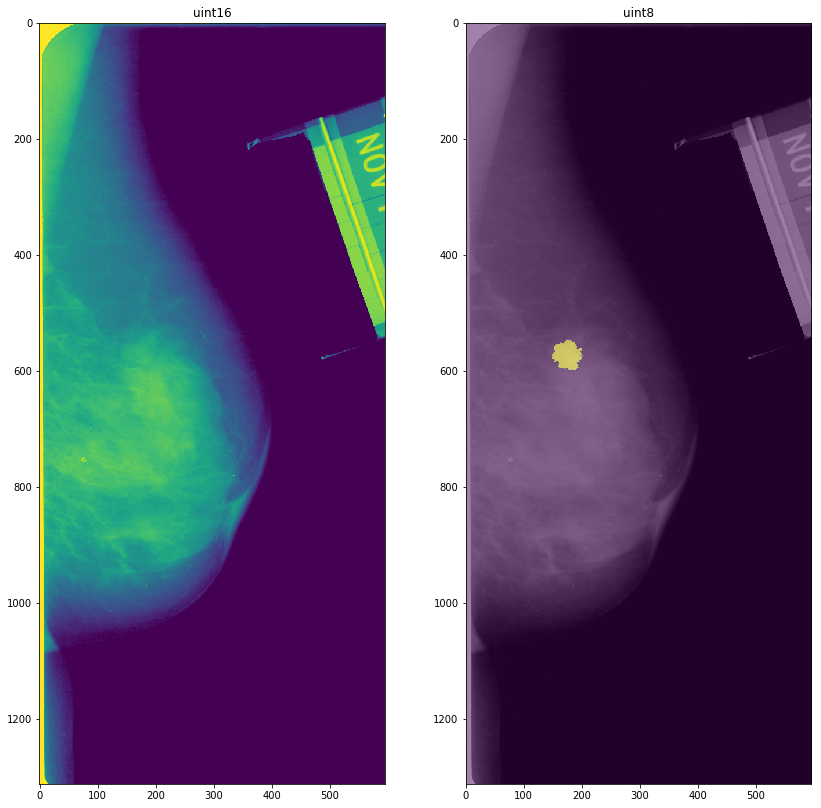

In [19]:
def preview(ent):
    with pydicom.dcmread(ent['masks'][0]) as db:
        maskim = db.pixel_array[:]
    with pydicom.dcmread(ent['image']) as db:
        img = db.pixel_array[:]
    print(maskim.shape, img.shape)

    plt.figure(figsize=(14, 14))
    plt.subplot(1, 2, 1)
    plt.gca().set_title(img.dtype)
    plt.imshow(cv2.resize(img, (0,0), fx=0.25, fy=0.25))
    plt.subplot(1, 2, 2)
    plt.gca().set_title(maskim.dtype)
    plt.imshow(cv2.resize(img, (0,0), fx=0.25, fy=0.25), cmap='gray')
    plt.imshow(cv2.resize(maskim, (0,0), fx=0.25, fy=0.25), alpha=0.5)
    plt.show()
    plt.close()
    
preview(tosave[0])

In [20]:
many = [ent for ent in tosave if len(ent['masks']) > 5]
print(len(many))

11


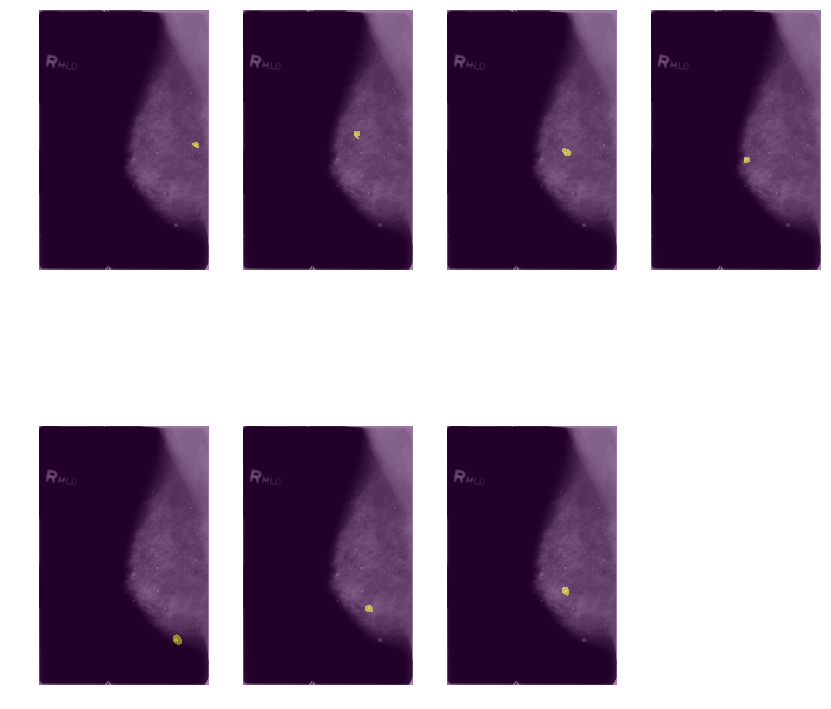

In [21]:
def preview_many(ent):
    plt.figure(figsize=(14, 14))
    for ii in range(len(ent['masks'])):
        plt.subplot(2, 4, ii+1)
        plt.axis('off')
        with pydicom.dcmread(ent['image']) as db:
            img = db.pixel_array[:]
        with pydicom.dcmread( ent['masks'][ii]) as db:
            maskim = db.pixel_array[:]
            plt.imshow(cv2.resize(img, (0,0), fx=0.25, fy=0.25), cmap='gray')
            plt.imshow(cv2.resize(maskim, (0,0), fx=0.25, fy=0.25), alpha=0.5)
    plt.show()
    plt.close()
    
preview_many(many[0])

In [22]:
def gather_rois(case):
    rois = []
    for mpath in case['masks']:
        with pydicom.dcmread(mpath) as db:
            mask = db.pixel_array[:]
        roi = np.nonzero(mask)
        rois.append(roi)
    return rois

roi_lookup = {}
for ii, case in enumerate(tosave):
    roi_lookup[case['sid']] = gather_rois(case)
    
    sys.stdout.write('%d/%d   \r' % (ii, len(tosave)))
    sys.stdout.flush()
#     break

In [24]:
from random import randint

def draw_sample(rawimg, rawmask, yy, xx, size=256, pad=128, case=None):
    size += pad
    half = size//2
    x0, y0 = max(0, xx-half), max(0, yy-half)
    xf, yf = min(rawimg.shape[1]-1, x0+size), min(rawimg.shape[0]-1, y0+size)
    x0, y0 = xf - size, yf - size
    
    img = rawimg[y0:yf, x0:xf]
    mask = rawmask[y0:yf, x0:xf]
    try:
        assert img.shape == (size, size)
        assert mask.shape == (size, size)
    except:
        raise Exception('Sample mismatch: %s %s' %(img.shape, mask.shape))
    return img, mask

SAVEPATH = '/home/ubuntu/datasets/tissue/cancers'
import h5py
__mismatch = 0
def sample_boxes(case, ratio=2000, maxout=50):
    global __mismatch
    samples = []
    sid = case['sid']
    many = roi_lookup[sid]
    with pydicom.dcmread(case['image']) as db:
        raw = db.pixel_array[:]
    assert len(many) > 0
    for mii, (roiY, roiX) in enumerate(many):
        samps = max(1, min(len(roiY) // ratio, maxout))
        try:
            assert samps > 0
        except:
            raise Exception('%d < %d' % (len(roiY), ratio))
        with pydicom.dcmread(case['masks'][mii]) as db:
            rawmask = db.pixel_array[:]
        try:
            assert raw.shape == rawmask.shape
        except:
            # some masks have been scaled down ~10% for some reason
            print('Mask mismatch: %s %s' %(raw.shape, rawmask.shape), case['sid'])
            __mismatch += 1
            continue
        for sii in range(samps):
            ind = randint(0, len(roiY)-1)
            yy, xx = roiY[ind], roiX[ind]
            img, mask = draw_sample(raw, rawmask, yy, xx, case=case)
            if img is None: continue # some error sampling
            
            ref = '%s_%s_%s' % (sid, mii, sii)
            mask_path = '%s/%s.jpg'% (SAVEPATH, ref)
            cv2.imwrite(mask_path, mask)
            img_path = '%s/%s.npy' % (SAVEPATH, ref)
            np.save(img_path, img)
            samples.append((img, mask))
        assert len(samples) > 0
    return samples, (raw, rawmask)

skip = 0
for ii, case in enumerate(tosave[skip:]):
    samples, (im, msk) = sample_boxes(case)
    if len(samples) == 0: continue
        
    imgs, masks = zip(*samples)
    if len(imgs) == 1:
        print('One', case['sid'])
    
    sys.stdout.write('%d/%d  Miss: %d   \r' % (ii, len(tosave)-skip, __mismatch))
    sys.stdout.flush()

One 00750_LEFT_MLO  
Mask mismatch: (5296, 3436) (4608, 2990) 00384_RIGHT_MLO
One 00562_RIGHT_MLO 
Mask mismatch: (5356, 2581) (4660, 2246) 00453_LEFT_CC
Mask mismatch: (5356, 2851) (4660, 2481) 00715_RIGHT_CC
Mask mismatch: (5296, 2566) (4608, 2233) 00687_LEFT_CC
Mask mismatch: (5236, 2971) (4556, 2585) 02092_LEFT_CC
Mask mismatch: (5026, 2836) (4373, 2468) 01908_LEFT_CC
Mask mismatch: (5296, 2566) (4608, 2233) 01048_RIGHT_CC
Mask mismatch: (5281, 2476) (4595, 2155) 00922_RIGHT_CC
One 01885_RIGHT_MLO 
Mask mismatch: (5266, 2761) (4582, 2403) 01048_RIGHT_MLO
Mask mismatch: (5356, 2326) (4660, 2024) 01363_RIGHT_MLO
Mask mismatch: (5386, 3436) (4686, 2990) 00108_LEFT_MLO
One 00476_LEFT_MLO   
Mask mismatch: (5386, 3316) (4686, 2885) 01243_LEFT_CC
Mask mismatch: (5386, 3466) (4686, 3016) 00059_LEFT_MLO
Mask mismatch: (5296, 3061) (4608, 2664) 00384_RIGHT_CC
Mask mismatch: (5386, 3436) (4686, 2990) 00703_LEFT_MLO
Mask mismatch: (5386, 3721) (4686, 3238) 01551_LEFT_CC
Mask mismatch: (5386, 